In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util

util.execute_notebook('structured_prediction.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Structured Prediction

No emerging unified _theory of NLP_, most textbooks and courses explain NLP as 

> a collection of problems, techniques, ideas, frameworks, etc. that really are not tied together in any reasonable way other than the fact that they have to do with NLP.
>
>  -- <cite>[Hal Daume](http://nlpers.blogspot.co.uk/2012/12/teaching-intro-grad-nlp.html)</cite>

but there is a reoccurring pattern ... the
## Structured Prediction Task

## Problem Signature 

* Given given some input structure \\(\x \in \Xs \\), such as a token, sentence, or document ...  
* predict an **output structure** \\(\y \in \Ys \\), such as a class label, a sentence or syntactic tree

## Recipes
* *Learn* how to **score** structures, **predict** by search for highest score
* *Learn* how to **predict** directly

## Recipe 1: Learn to Score, Implement How to Predict

 * Define a parametrised _model_ \\(s_\params(\x,\y)\\) that measures the _match_ of a given \\(\x\\) and \\(\y\\) using _representations_ $\repr(\x)$ and $\repry(\y)$.

 * _Learn_ the parameters \\(\params\\) from the training data \\(\train\\) to minimise a loss (a _continuous optimisation problem_).

 * Given an input \\(\x\\) find the highest-scoring output structure $$ \y^* = \argmax_{\y\in\Ys} s_\params(\x,\y) $$ (a _discrete optimisation problem_).  

**Good NLPers** combine **three skills** in accordance with this recipe: 

* modelling,
* continuous optimisation and
* discrete optimisation.

## Example
* Difficult to show meaningful example without going into depth (as we will do later)
* Instead consider toy example that uses same ingredients and steps

### Task
"Machine translation" from English into German sentences

### Assumptions
* There are only 4 target German sentences we care about.
* The lengths of the source English and target German sentences are sufficient representations of the problem.

### Training and Testing Data

In [2]:
util.Table(train, column_names=["x","y"])

x,y
I ate an apple,Ich aß einen Apfel
I ate a red apple,Ich aß einen roten Apfel


In [3]:
util.Table(test)  

Yesterday I ate a red apple,Gestern aß ich einen roten Apfel
Yesterday I ate a red apply with a friend,Gestern aß ich einen roten Apfel mit einem Freund


Our 
### Output Space
is simply:

In [4]:
y_space

['Ich aß einen Apfel',
 'Ich aß einen roten Apfel',
 'Gestern aß ich einen roten Apfel',
 'Gestern aß ich einen roten Apfel mit einem Freund']

### Representation
* $\repr(\x)=|\x|$ 
* $\repry(\y)=|\y|$ 

### Model
$$
s_\param(\x,\y) = -|\param \repr(\x) - \repry(\y)|
$$

Note: $\param$ should capture fact that German sentences are a little longer (here!)

Let us inspect this model: 

In [5]:
util.Table([(x, y, f(x), g(y), s(1.0, x, y)) for x, y in train],
           column_names=["Source x","Target y","f(x)","g(y)","score"])

Source x,Target y,f(x),g(y),score
I ate an apple,Ich aß einen Apfel,14,18,-4.00
I ate a red apple,Ich aß einen roten Apfel,17,24,-7.00


Does this scoring function help to **discriminate** right from wrong? 

In [13]:
util.Table([(train[1][0],y,"{:.2f}".format(s(1.3,train[1][0],y))) 
            for y in y_space],
           column_names=["Source x","Target y","score"])

Source x,Target y,score
I ate a red apple,Ich aß einen Apfel,-4.10
I ate a red apple,Ich aß einen roten Apfel,-1.90
I ate a red apple,Gestern aß ich einen roten Apfel,-9.90
I ate a red apple,Gestern aß ich einen roten Apfel mit einem Freund,-26.90


How to estimate $\param$? Let us define a 
### Loss Function
$$
l(\param)=\sum_{(\x,\y) \in \train} \indi(\y\neq\y^*_{\param}(\x))
$$
where 
* $\indi(\mathrm{True})=1$ and $\indi(\mathrm{False})=0$ 
* $\y^*_{\param}(\x) \in \Ys$ is highest scoring translation of $\x$
$$\y^*_{\param}(\x)=\argmax_\y s_\param(\x,\y).$$


A finite approximation of the search space ...

In [7]:
thetas = np.linspace(0.0, 2.0, num=50)

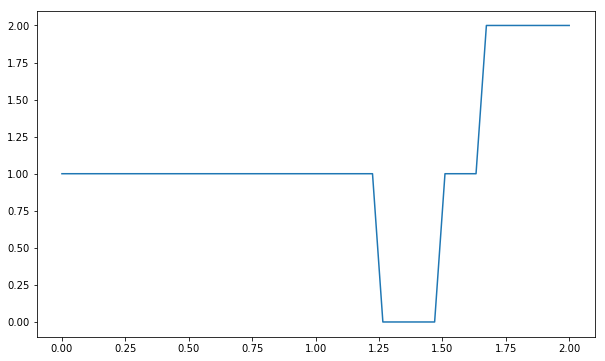

In [8]:
plt.plot(thetas, [loss(theta,train) for theta in thetas])

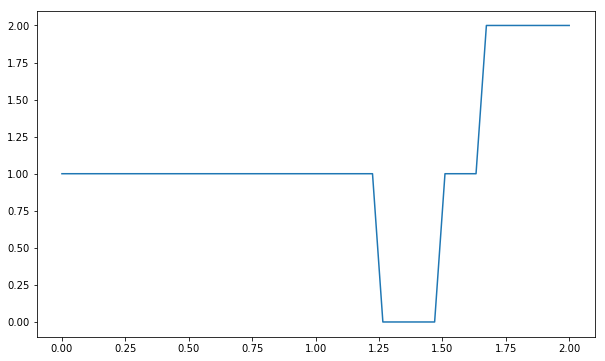

In [8]:
plt.plot(thetas, [loss(theta,train) for theta in thetas])

What do you observe here? What does it mean for our prediction task? Discuss with your neighbour and enter your answer here: https://tinyurl.com/ya57djqr

### Learning
is as simple as choosing the parameter with the lowest loss:

$$
\param^* = \argmin_{\param \in [0,2]} l(\param) 
$$


In [10]:
theta_star = thetas[np.argmin([loss(theta,train) for theta in thetas])]
theta_star

1.2653061224489794

### Prediction
same thing, just in $\Ys$:

$$\y{^*}_{\param}=\argmax_\y s_\param(\x,\y).$$

Seen before? Yes, training often involves prediction in inner loop.

In [11]:
util.Table([(x,predict(theta_star, x)) for x,_ in test])

Yesterday I ate a red apple,Gestern aß ich einen roten Apfel
Yesterday I ate a red apply with a friend,Gestern aß ich einen roten Apfel mit einem Freund


### In Practice
Feature representations and scoring functions are **more elaborate**
* involve several **non-linear** transformations of both input and output 
* Maybe learn automatically: **representation** and **deep learning**

Parameter space usually **multi-dimensional** (millions of dimensions). 
* **Impossible to search exhaustively**.
* **Numeric optimisation algorithms** (often SGD).

Output space often exponentional sized (e.g. *all* German sentences)
* **Impossible to search exhaustively**.
* **Discrete optimisation algorithms** (Dynamic Programming, Greedy, integer linear programming)

## Summary of Recipe 1: Learn to Score, Implement How to Predict

* Learn a scoring function
* Find the highest scoring solution using a discrete algorithm

* Could we alternatively learn the prediction or search algorithm directly? Yes, with...

## Recipe 2: Learn to Predict

* Consider language processing as a **program**
* Learn which **action** the program should do at each stage
* For example:
    * actions are "adding a word to a translation"
    * program performs actions until all source words are translated
* Can be framed as 
    * reinforcement learning 
    * [imitation learning](https://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf)
* Will see this in [dependency parsing](/notebooks/chapters/Transition-based%20dependency%20parsing.ipynb) 
    
 

## Background Reading

* Noah Smith, [Linguistic Structure Prediction](http://www.cs.cmu.edu/~nasmith/LSP/)
    * Free when logging in through UCPH 
    * Relevant: 
        * Introduction
        * Dynamic Programming 
        * Generative Models (and unsupervised generative models)
        * Globally Normalised Conditional Log-Linear Models  
   